<a href="https://colab.research.google.com/github/sahupra1357/timeseries/blob/main/Tensorflow_LSTM_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [68]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [69]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [70]:
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv",parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [71]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
#print(dataset.head(5))
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [72]:
#values = dataset[:10].values
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [73]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [74]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048


In [75]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [76]:
train_X

array([[[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001,
         0.        , 0.        ]],

       [[0.14889336, 0.36764708, 0.24590163, ..., 0.00381099,
         0.        , 0.        ]],

       [[0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.32352942, 0.22950819, ..., 0.10542597,
         0.        , 0.        ]],

       [[0.        , 0.32352942, 0.16393442, ..., 0.11229601,
         0.        , 0.        ]],

       [[0.        , 0.33823532, 0.1967213 , ..., 0.12070411,
         0.        , 0.        ]]], dtype=float32)

In [77]:
train_y

array([0.14889336, 0.15995975, 0.18209255, ..., 0.        , 0.        ,
       0.0362173 ], dtype=float32)

Epoch 1/50
122/122 - 5s - loss: 0.0550 - val_loss: 0.0590 - 5s/epoch - 43ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0363 - val_loss: 0.0580 - 2s/epoch - 14ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0214 - val_loss: 0.0499 - 2s/epoch - 17ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0173 - val_loss: 0.0416 - 2s/epoch - 18ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0158 - val_loss: 0.0266 - 2s/epoch - 14ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0151 - val_loss: 0.0201 - 2s/epoch - 14ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0148 - val_loss: 0.0186 - 2s/epoch - 15ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0151 - val_loss: 0.0177 - 2s/epoch - 15ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0149 - val_loss: 0.0164 - 2s/epoch - 14ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0155 - 1s/epoch - 10ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0147 - val_loss: 0.0151 - 2s/epoch - 14ms/step
Epoch 12/50
122/122 - 2s - loss: 0.0146 - val_loss: 0.0146 - 2s/epoch - 14ms/step
Epoch 13/50
122/122 - 2s 

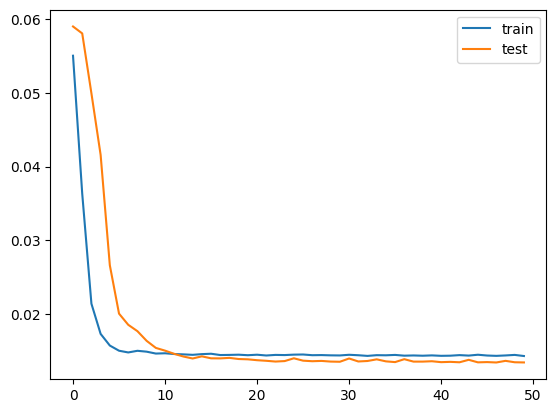

In [78]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [79]:
# make a prediction
yhat = model.predict(test_X)
print(yhat.shape)
yhat

1095/1095 [==============================] - 3s 2ms/step
(35039, 1)


array([[0.03489287],
       [0.03157291],
       [0.0208393 ],
       ...,
       [0.0082649 ],
       [0.00825018],
       [0.00647452]], dtype=float32)

In [80]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)
test_X

(35039, 8)


array([[0.0362173 , 0.33823532, 0.1967213 , ..., 0.12757413, 0.        ,
        0.        ],
       [0.03118712, 0.33823532, 0.1967213 , ..., 0.006101  , 0.        ,
        0.        ],
       [0.02012072, 0.33823532, 0.1967213 , ..., 0.0145091 , 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.40558836, 0.        ,
        0.        ],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ]], dtype=float32)

In [81]:
DataFrame(test_X[:, 1:])

,0,1,2,3,4,5,6
0,0.338235,0.196721,0.836365,0.333333,0.127574,0.0,0.0
1,0.338235,0.196721,0.836365,0.000000,0.006101,0.0,0.0
2,0.338235,0.196721,0.836365,0.000000,0.014509,0.0,0.0
3,0.323529,0.180328,0.836365,0.333333,0.006101,0.0,0.0
4,0.323529,0.180328,0.836365,0.000000,0.006101,0.0,0.0
...,...,...,...,...,...,...,...
35034,0.264706,0.278689,0.763638,0.333333,0.385730,0.0,0.0
35035,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0
35036,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0
35037,0.264706,0.262295,0.781818,0.333333,0.413996,0.0,0.0


In [82]:
yhat.shape

(35039, 1)

In [83]:
test_X[:, 1:].shape

(35039, 7)

In [84]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat

array([[0.03489287, 0.33823532, 0.1967213 , ..., 0.12757413, 0.        ,
        0.        ],
       [0.03157291, 0.33823532, 0.1967213 , ..., 0.006101  , 0.        ,
        0.        ],
       [0.0208393 , 0.33823532, 0.1967213 , ..., 0.0145091 , 0.        ,
        0.        ],
       ...,
       [0.0082649 , 0.2647059 , 0.26229507, ..., 0.40558836, 0.        ,
        0.        ],
       [0.00825018, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00647452, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ]], dtype=float32)

In [85]:
inv_yhat.shape

(35039, 8)

In [86]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [87]:
test_y.shape

(35039,)

In [88]:
test_y = test_y.reshape((len(test_y), 1))
test_y

array([[0.03118712],
       [0.02012072],
       [0.01911469],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]], dtype=float32)

In [89]:
import numpy as np
np.isnan(test_y).sum()

0

In [90]:
inv_yhat

array([34.683514, 31.383476, 20.714268, ...,  8.215315,  8.200683,
        6.435674], dtype=float32)

In [91]:
# invert scaling for actual

inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.556


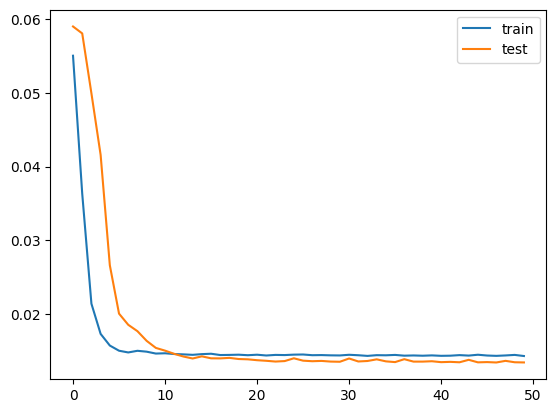

In [92]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()